# Introduction

O arquivo usado para extração de texto foi o arquivo da Organização Mundial da Saúde chamado World health statistics 2024 Monitoring health for the SDGs: Sustainable Development Goals. Disponível em: https://iris.who.int/bitstream/handle/10665/376869/9789240094703-eng.pdf?sequence=1 e https://www.who.int/publications/i/item/9789240094703

The file used to extract text was the World Health Organization called World health statistics 2024 Monitoring health for the SDGs: Sustainable Development Goals. Access at: https://iris.who.int/bitstream/handle/10665/376869/9789240094703-eng.pdf?sequence=1 and https://www.who.int/publications/i/item/9789240094703

## Installing libraries, packages and models

In [ ]:
!python -m spacy download en_core_web_md
#!pip install -U nltk
#!python -m nltk.downloader all
!pip install PyPDF2
#!pip install sknetwork
!pip install scikit-network

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Importing labraries and packages

In [ ]:
import spacy
import requests
import pandas as pd
#import nltk
import PyPDF2
import re
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse as sp
import numpy as np

from IPython.display import SVG
from sknetwork.visualization import svg_graph
from sknetwork.data import Bunch
from sknetwork.ranking import PageRank
from bs4 import BeautifulSoup
#from nltk.tokenize import sent_tokenize
#from nltk.tokenize import casual_tokenize

## Getting text and text cleaning

In [ ]:
#### Loading SPACY's model "en_core_web_md" and downloading NLTK's model "averaged_perceptron_tagger_eng"

nlp = spacy.load("en_core_web_md")
#nltk.download('averaged_perceptron_tagger_eng')


In [ ]:
#### Defining a function to extract the PDF text content
### To extract the WHO file, download it from the links given at the beginning and put it's name at the second to last line.

def extract_text_from_pdf(pdf_path):
    text = ""
    with open(pdf_path, 'rb') as pdf_file:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            text += page.extract_text()
    return text

# Replace 'oms.pdf' with the path to your PDF file or the name of the file
pdf_text = extract_text_from_pdf('oms.pdf')
pdf_text

'World health   \nstatistics 2024\nMonitoring health for the SDGs,  \nSustainable Development GoalsWorld health   \nstatistics 2024\nMonitoring health for the SDGs,  \nSustainable Development GoalsWorld health statistics 2024: monitoring health for the SDGs, Sustainable Development Goals  \n \nISBN 978-92-4-009470-3 (electronic version) ISBN 978-92-4-009471-0 (print version)\n© World Health Organization 2024\nSome rights reserved. This work is available under the Creative Commons Attribution-NonCommercial-ShareAlike 3.0  IGO \nlicence (CC  BY-NC-SA  3.0 IGO; https://creativecommons.org/licenses/by-nc-sa/3.0/igo). \nUnder the terms of this licence, you may copy, redistribute and adapt the work for non-commercial purposes, provided the work is appropriately cited, as indicated below. In any use of this work, there should be no suggestion that WHO endorses any specific organization, products or services. The use of the WHO logo is not permitted. If you adapt the work, then you must licens

In [ ]:
print(len(pdf_text))

262259


In [ ]:
print(spacy.explain("GPE"))
print(spacy.explain("PERSON"))
print(spacy.explain("ORG"))

Countries, cities, states
People, including fictional
Companies, agencies, institutions, etc.


In [ ]:
cutoffup = pdf_text.index('In just two years,') ## Defining a string to be the point in the text to be the start point of the text to be processed.
print(cutoffup)
cutoffdown = pdf_text.index('specialized care and mental health services.') ## Defining a string to be a point in the text to be the end point of the text to be processed.
print(cutoffdown)

text = pdf_text[cutoffup:cutoffdown] ## Cutting pdf_text's text from start point to end point and assigning it to text.
print("text:",text)

## Remove non-alphabetic characters
oms_text = re.sub(r'\d+', '', text)

## Removing symbols and other characters
oms_text = oms_text.replace(':', ' ').replace(';',' ').replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('\xa0', ' ').replace(',',' ').replace('(', ' ').replace(')',' ').replace('  ', ' ').replace('\\', ' ').replace('/', ' ')#.lower()

print("oms:", oms_text)


12312
246440
text: In just two years, the COVID-19 pandemic reversed over 
a decade of gains in both life expectancy at birth and 
healthy life expectancy (HALE). By 2020, both global 
life expectancy and HALE had rolled back to 2016 levels 
(72.5  years and 62.8 years, respectively). The following 
year saw further declines, with both retreating to 2012 levels (71.4 years and 61.9 years, respectively).
The WHO regions most affected were the Region of the 
Americas and South-East Asia Region, with declines of 
about 3 years in life expectancy and 2.5 years in HALE 
between 2019 and 2021. The Western Pacific Region saw 
the smallest impacts over the first two pandemic years, 
with losses of less than 0.1 and 0.2 years in life expectancy 
and HALE, respectively.
Globally, the share of deaths from noncommunicable 
diseases (NCDs) among all deaths rose steadily to 73.9% by 2019, while the share of communicable diseases 
dropped to 18.2%. With the emergence of COVID-19, 
communicable diseas

In [ ]:
#### Defining the function to extract entities from sentences using SPACY. Adapted from reference: https://github.com/ivanovitchm/datastructure/blob/main/lessons/final/chapter_4.ipynb

def extract_entities(sentence):
    """
    Extract named entities (PERSON, ORG, GPE) from a sentence using spaCy.

    Args:
        sentence (str): The input sentence.

    Returns:
        list: A list of named entities found in the sentence.
    """
    entities = []

    doc = nlp(sentence)

    for token in doc:

        # Check if the token is a proper noun (NNP) and has a named entity type
        # of PERSON, ORG, or GPE
        if token.tag_ == 'NNP' and token.ent_type_ in ('PERSON', 'ORG', 'GPE'):
            entities.append(token.text)  # Append the token's text to the entities list
    return entities

In [ ]:
## Using spaCy's nlp model loaded beforehand to extract oms_text
doc = nlp(oms_text)
print(doc)

## Extracting sentences
sentences = list(doc.sents)
print("sentences 1:", sentences)
print(len(sentences))

## Reducing sentences to sentences with lenght higher than 3 to remove some not useful words.
sentences = [sentence for sentence in sentences if len(sentence) > 3]
print("sentences 2:", sentences)
print(len(sentences))

In just two years the COVID- pandemic reversed over a decade of gains in both life expectancy at birth and healthy life expectancy HALE . By  both global life expectancy and HALE had rolled back to levels  . years and . years respectively . The following year saw further declines with both retreating to levels . years and . years respectively . The WHO regions most affected were the Region of the Americas and South-East Asia Region with declines of about years in life expectancy and . years in HALE between and . The Western Pacific Region saw the smallest impacts over the first two pandemic years  with losses of less than . and . years in life expectancy and HALE respectively. Globally the share of deaths from noncommunicable diseases NCDs among all deaths rose steadily to .% by  while the share of communicable diseases dropped to .%. With the emergence of COVID-  communicable diseases surged back to .% of all deaths in and .% in – a return to levels. Consequently the share of NCD deat

In [ ]:
#### Generating nodes list with format [source, target] based on entity extraction from each sentence in sentences.

entities = []
nodes = []

for sentence in sentences:

  entities = (extract_entities(sentence.text))
  #print(entities)

  if entities:
    source = entities[0] ## Extract the text attribute of the token
    #print(source)

    for target in entities[1:]: ## Iterate over tokens in the sentence starting from the second token
      if (target.lower()) != source.lower():
          #print(target)
          nodes.append([source, target])
          #print(nodes)

print(nodes)
print(len(nodes))
print(entities)
print(len(entities))

[['WHO', 'Region'], ['UI', 'Fig'], ['SDGs', 'Sustainable'], ['SDGs', 'Development'], ['UI', 'HALE'], ['HALE', 'World'], ['HALE', 'Bank'], ['HALE', 'World'], ['HALE', 'Bank'], ['HALE', 'Fig'], ['World', 'Bank'], ['SDGs', 'Sustainable'], ['SDGs', 'Development'], ['NCD', 'Fig'], ['World', 'Bank'], ['World', 'Fig'], ['SDGs', 'Sustainable'], ['SDGs', 'Development'], ['SDGs', 'Figure'], ['World', 'Bank'], ['Region', 'ASDR'], ['World', 'Bank'], ['World', 'ASDR'], ['SDGs', 'Sustainable'], ['SDGs', 'Development'], ['SDGs', 'Figure'], ['World', 'Bank'], ['World', 'Kidney'], ['SDGs', 'Sustainable'], ['SDGs', 'Development'], ['MMR', 'ARR'], ['MMR', 'SDG'], ['Region', 'MDG'], ['SDG', 'ARR'], ['UI', 'UMR'], ['SDGs', 'Sustainable'], ['SDGs', 'Development'], ['SDGs', 'Newborn'], ['UMR', 'NMR'], ['UMR', 'SDG'], ['UMR', 'MDG'], ['ARR', 'UMR'], ['United', 'Nations'], ['United', 'Decade'], ['United', 'Action'], ['United', 'Road'], ['United', 'Safety'], ['United', 'Nations'], ['United', 'Decade'], ['United

In [ ]:
#### Creating Graph with NetworkX and adding the node and edges based on nodes list

graph = nx.Graph()
for source, target in nodes:
    graph.add_edge(str(source), str(target)) # Convert to string if necessary

graph.remove_edges_from(nx.selfloop_edges(graph)) ## Removing selfloops

print(graph.number_of_nodes())
print(graph.number_of_edges())

print(list(graph.nodes))
print(list(graph.edges))

269
397
['WHO', 'Region', 'UI', 'Fig', 'SDGs', 'Sustainable', 'Development', 'HALE', 'World', 'Bank', 'NCD', 'Figure', 'ASDR', 'Kidney', 'MMR', 'ARR', 'SDG', 'MDG', 'UMR', 'Newborn', 'NMR', 'United', 'Nations', 'Decade', 'Action', 'Road', 'Safety', 'CDR', 'European', 'Eastern', 'Mediterranean', 'Geneva', 'Health', 'Organization', 'Agenda', 'General', 'Assembly', 'New', 'York', 'Group', 'UNDESA', 'Population', 'Division', 'Inter', 'agency', 'Child', 'Mortality', 'Estimation', 'Children', 'Fund', 'Department', 'Economic', 'Social', 'UNIGME--Child-Mortality-Report.pdf', 'en&v', 'Global', 'RTS', 'S', 'Ghana', 'Kenya', 'Malawi', 'Malaria', 'Vaccine', 'Implementation', 'Programme', 'Box', 'Plasmodium', 'rubella', 'Coverage', 'Gavi', 'Alliance', 'Benin', 'Burkina', 'Faso', 'Cameroon', 'Liberia', 'Sierra', 'Leone', 'Hepatitis', 'B', 'C', 'Western', 'Pacific', 'Bangladesh', 'kala', 'azar', 'India', 'Nepal', 'Regional', 'Kala', 'Government', 'Special', 'Research', 'Training', 'Tropical', 'Maldiv

In [ ]:
# prompt: print graphs information

print(graph.number_of_nodes())
print(graph.number_of_edges())

print(list(graph.nodes))
print(list(graph.edges))

# Degree Centrality
degree_centrality = nx.degree_centrality(graph)
print("Degree Centrality:", degree_centrality)

# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(graph)
print("Betweenness Centrality:", betweenness_centrality)

# Closeness Centrality
closeness_centrality = nx.closeness_centrality(graph)
print("Closeness Centrality:", closeness_centrality)

# Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(graph)
print("Eigenvector Centrality:", eigenvector_centrality)


# PageRank
pagerank = nx.pagerank(graph)
print("PageRank:", pagerank)

269
397
['WHO', 'Region', 'UI', 'Fig', 'SDGs', 'Sustainable', 'Development', 'HALE', 'World', 'Bank', 'NCD', 'Figure', 'ASDR', 'Kidney', 'MMR', 'ARR', 'SDG', 'MDG', 'UMR', 'Newborn', 'NMR', 'United', 'Nations', 'Decade', 'Action', 'Road', 'Safety', 'CDR', 'European', 'Eastern', 'Mediterranean', 'Geneva', 'Health', 'Organization', 'Agenda', 'General', 'Assembly', 'New', 'York', 'Group', 'UNDESA', 'Population', 'Division', 'Inter', 'agency', 'Child', 'Mortality', 'Estimation', 'Children', 'Fund', 'Department', 'Economic', 'Social', 'UNIGME--Child-Mortality-Report.pdf', 'en&v', 'Global', 'RTS', 'S', 'Ghana', 'Kenya', 'Malawi', 'Malaria', 'Vaccine', 'Implementation', 'Programme', 'Box', 'Plasmodium', 'rubella', 'Coverage', 'Gavi', 'Alliance', 'Benin', 'Burkina', 'Faso', 'Cameroon', 'Liberia', 'Sierra', 'Leone', 'Hepatitis', 'B', 'C', 'Western', 'Pacific', 'Bangladesh', 'kala', 'azar', 'India', 'Nepal', 'Regional', 'Kala', 'Government', 'Special', 'Research', 'Training', 'Tropical', 'Maldiv

In [ ]:
#### Defining functions to draw a Graph and a Ego Graph

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5):

    adjacency = nx.adjacency_matrix(G, weight='weight')
    adjacency = sp.csr_matrix(adjacency)

    names = np.array(list(G.nodes()))

    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)

    pagerank = PageRank()

    pagerank.fit(adjacency)
    scores = pagerank.scores_

    if show_names:

        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)

    else:

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width)

    return SVG(image)

def draw_ego_graph(G, ego, center=True, k=0, show_names=True, edge_width=0.1, node_size=3, font_size=12):

    ego = nx.ego_graph(G, ego, center=center)
    print(ego.number_of_nodes())

    ego = nx.k_core(ego, k)

    return draw_graph(ego, node_size=node_size, font_size=font_size, show_names=show_names, edge_width=edge_width)

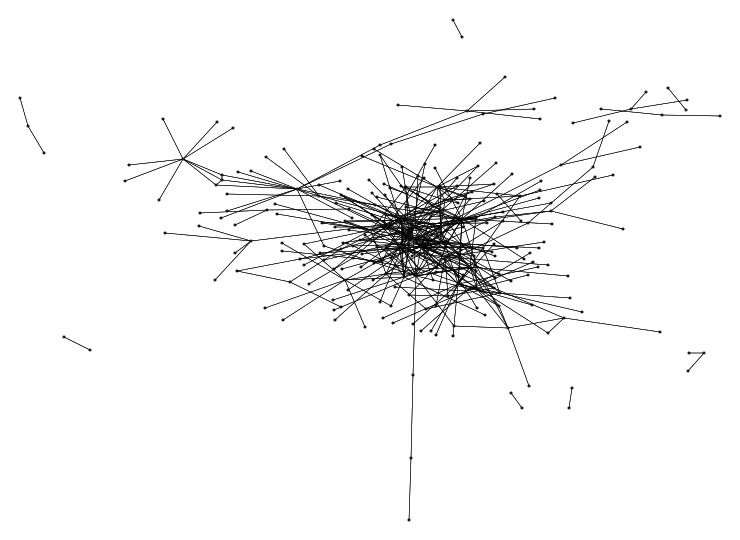

In [ ]:
draw_graph(graph)

In [ ]:
#### Importing the graph as gexf file to open with Gephi

nx.write_gexf(graph, "my_graph.gexf")

In [ ]:
#### Getting the highest degree
degree_sequence = list(dict(graph.degree()).values()) # Get the degree values

print(degree_sequence)
print(max(degree_sequence))

[11, 8, 11, 13, 16, 2, 4, 4, 28, 6, 1, 1, 2, 1, 2, 3, 5, 6, 5, 1, 1, 19, 7, 1, 4, 1, 1, 2, 9, 2, 1, 25, 21, 7, 6, 4, 6, 20, 1, 5, 1, 2, 2, 1, 1, 1, 1, 1, 3, 3, 2, 2, 2, 1, 1, 15, 12, 2, 4, 3, 3, 1, 2, 1, 4, 2, 1, 1, 1, 2, 1, 9, 1, 1, 1, 1, 1, 1, 5, 1, 2, 1, 2, 11, 2, 3, 1, 1, 5, 2, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 9, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 13, 1, 2, 1, 1, 1, 4, 6, 15, 4, 1, 1, 1, 1, 11, 14, 4, 1, 1, 3, 2, 1, 2, 2, 2, 1, 19, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 14, 2, 3, 4, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 4, 1, 1, 1, 1, 3, 1, 1, 1, 8, 3, 1, 1, 7, 1, 5, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 3, 1, 6, 1, 3, 1, 1, 6, 1, 2, 2, 2, 3, 1, 5, 1, 1, 1, 1, 5, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1]
28


29


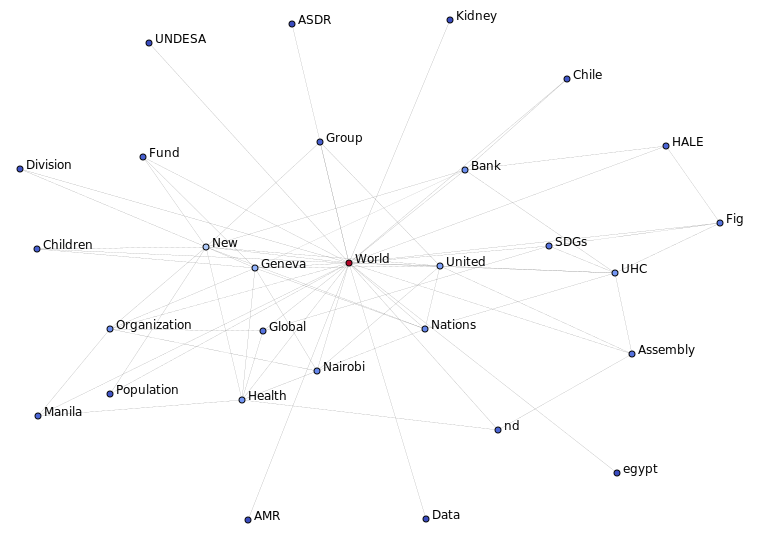

In [ ]:
#### After seeing in Gephi the node with higher degree and its name is possible to create it's ego network.
draw_ego_graph(graph, "World")